In [29]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('..')
from importlib import reload
from run.domain_coverage import DomainTree
import stats
reload(stats)

CONF_DIR = Path('../conf/').resolve()
DATA_DIR = Path('../data/').resolve()

def clean_domains(df):
    BAD_DOMAINS_PREFIX = [
        "*",
        "nan",
        "[$",
        ".", 
        "/]",
        "/^",
        "/",
        "\\\\/",
        "~",
    ]

    return df[(df['domain'].str.startswith(tuple(BAD_DOMAINS_PREFIX)) == False)].copy()

LIST_IDENTIFIABLE_RULE_COUNTS = {
    
    "adguard":{
        "all": pd.read_csv(DATA_DIR / 'filterlists/adguard/fingerprint/stat-generic/unique_counts.csv'),
        "cosmetic": pd.read_csv(DATA_DIR / 'filterlists/adguard/fingerprint/stat-generic-cosmetic/unique_counts.csv'),
        "network": pd.read_csv(DATA_DIR / 'filterlists/adguard/fingerprint/stat-generic-network/unique_counts.csv'),
    },
    
    "ublock":{
        "all": pd.read_csv(DATA_DIR / 'filterlists/ublock/fingerprint/stat-generic/unique_counts.csv'),
        "cosmetic": pd.read_csv(DATA_DIR / 'filterlists/ublock/fingerprint/stat-generic-cosmetic/unique_counts.csv'),
        "network": pd.read_csv(DATA_DIR / 'filterlists/ublock/fingerprint/stat-generic-network/unique_counts.csv'),
    }
}

DOMAIN_SPECIFIC_STATS = {
    "adguard": {
        "all": clean_domains(pd.read_csv(DATA_DIR / 'filterlists/adguard/domain_coverage/.analysis/coverage_count_rules.csv')),
        "cosmetic": clean_domains(pd.read_csv(DATA_DIR / 'filterlists/adguard/domain_coverage/.analysis/coverage_count_cosmetic_rules.csv')),
        "network": clean_domains(pd.read_csv(DATA_DIR / 'filterlists/adguard/domain_coverage/.analysis/coverage_count_network_rules.csv')),
    },
    "ublock": {
        "all": clean_domains(pd.read_csv(DATA_DIR / 'filterlists/ublock/domain_coverage/.analysis/coverage_count_rules.csv')),
        "cosmetic": clean_domains(pd.read_csv(DATA_DIR / 'filterlists/ublock/domain_coverage/.analysis/coverage_count_cosmetic_rules.csv')),
        "network": clean_domains(pd.read_csv(DATA_DIR / 'filterlists/ublock/domain_coverage/.analysis/coverage_count_network_rules.csv')),
    }
}

TOP_1K_DOMAINS = pd.read_csv(CONF_DIR / 'tranco_24P99.csv', header=None, names=['rank', 'domain'])

In [24]:
reload(stats)
# Count the domains
table = []

for adblocker in ["adguard", "ublock"]:
    for rule_type in ["all", "cosmetic", "network"]:
        domain_count = DOMAIN_SPECIFIC_STATS[adblocker][rule_type]
        table.append({"adblocker": adblocker, "rule_type": rule_type,**stats.domain_counts_stats(domain_count)})
        
        
pd.DataFrame(table)


,adblocker,rule_type,n_domains,max_rules,min_rules,median_rules,max_lists,min_lists,median_lists
0,adguard,all,137760,128159.0,1.0,3.0,45,1,2.0
1,adguard,cosmetic,128123,123201.0,1.0,3.0,41,1,2.0
2,adguard,network,27007,4503.0,1.0,2.0,18,1,1.0
3,ublock,all,133398,50909.0,1.0,2.0,34,1,1.0
4,ublock,cosmetic,124233,46696.0,1.0,2.0,31,1,1.0
5,ublock,network,26611,671.0,1.0,1.0,11,1,1.0


Processing adguard all list
Total lists: 83, Unique lists: 71
Domain: translate.google.*, Additional lists: 13, Total lists: 84
Processing adguard cosmetic list
Total lists: 83, Unique lists: 58
Domain: adguard.com, Additional lists: 15, Total lists: 73
Domain: blogspot.com, Additional lists: 5, Total lists: 78
Domain: baidu.com, Additional lists: 1, Total lists: 79
Domain: \tallegro.pl, Additional lists: 1, Total lists: 80
Domain: ro, Additional lists: 0, Total lists: 80
Processing adguard network list
Total lists: 83, Unique lists: 70
Domain: tvn24.pl, Additional lists: 6, Total lists: 76
Domain: m.ua, Additional lists: 3, Total lists: 79
Domain: op.gg, Additional lists: 2, Total lists: 81
Domain: jut.su, Additional lists: 1, Total lists: 82
Domain: avic.ua, Additional lists: 1, Total lists: 83
Processing ublock all list
Total lists: 63, Unique lists: 63
Processing ublock cosmetic list
Total lists: 63, Unique lists: 54
Domain: bing.com, Additional lists: 3, Total lists: 57
Domain: am

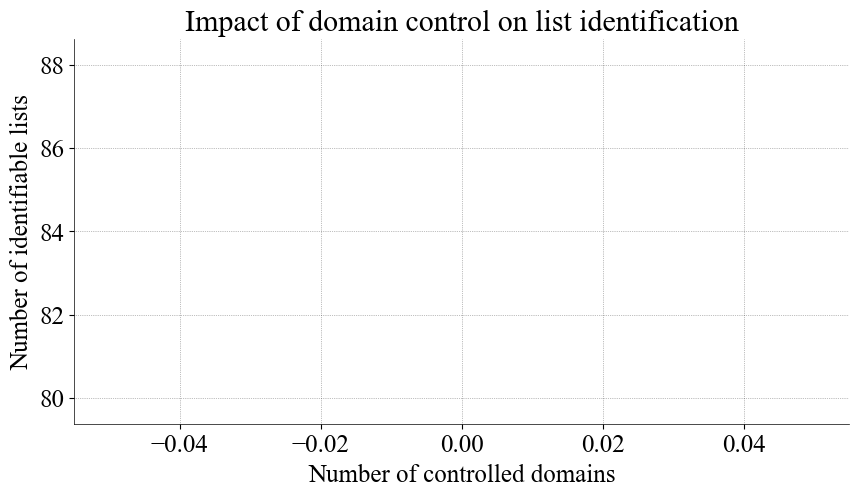

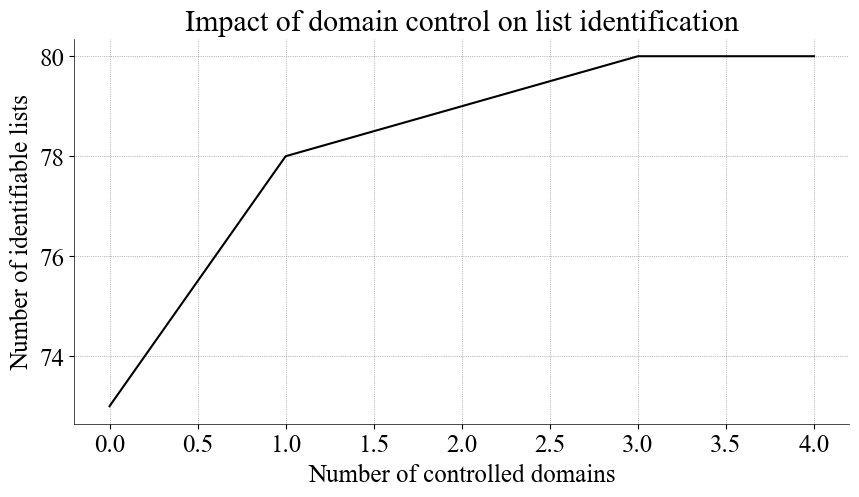

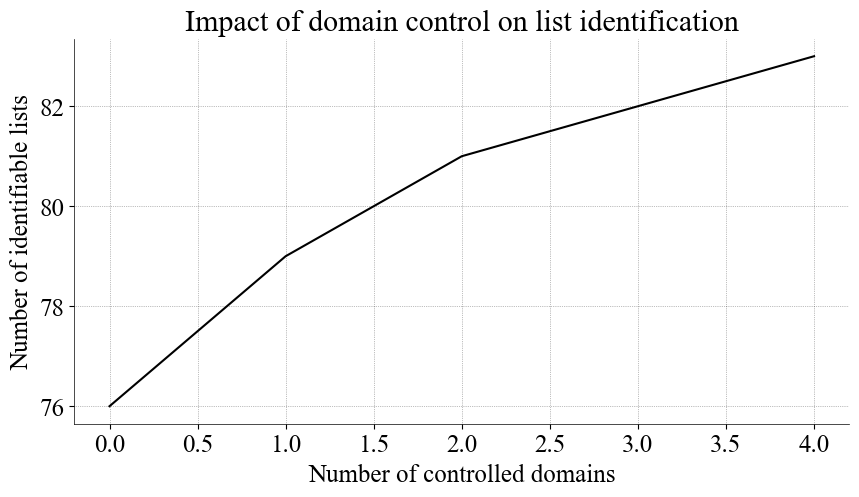

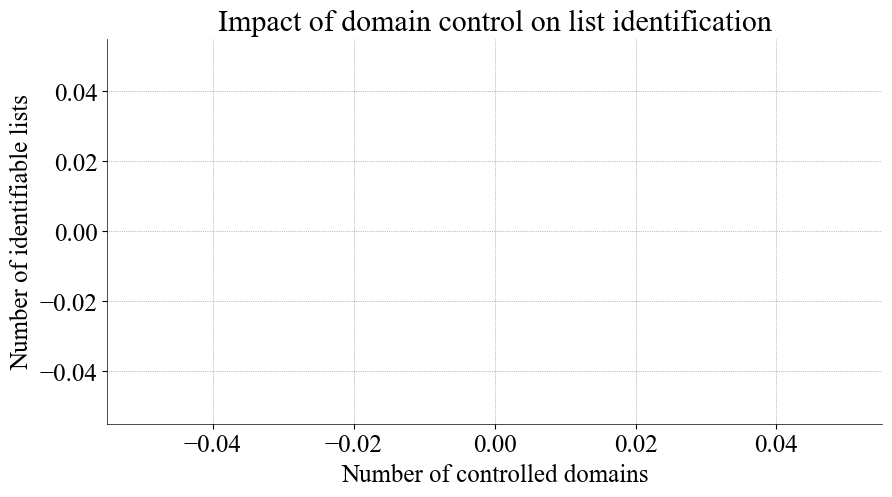

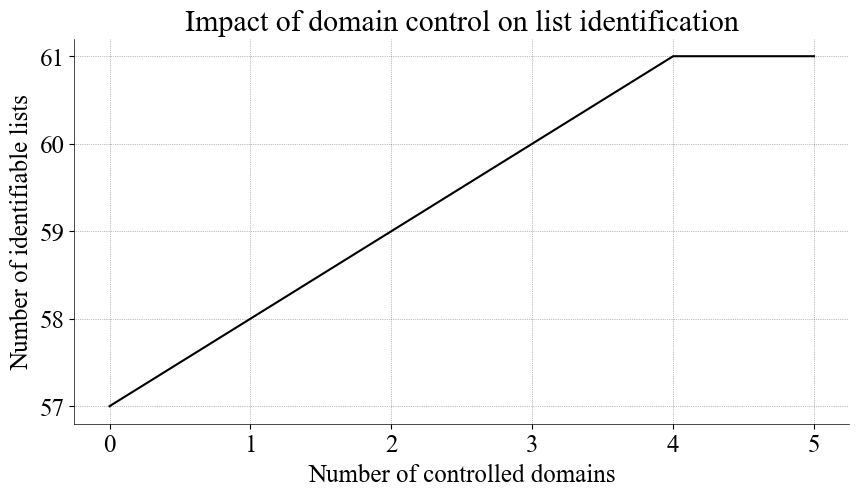

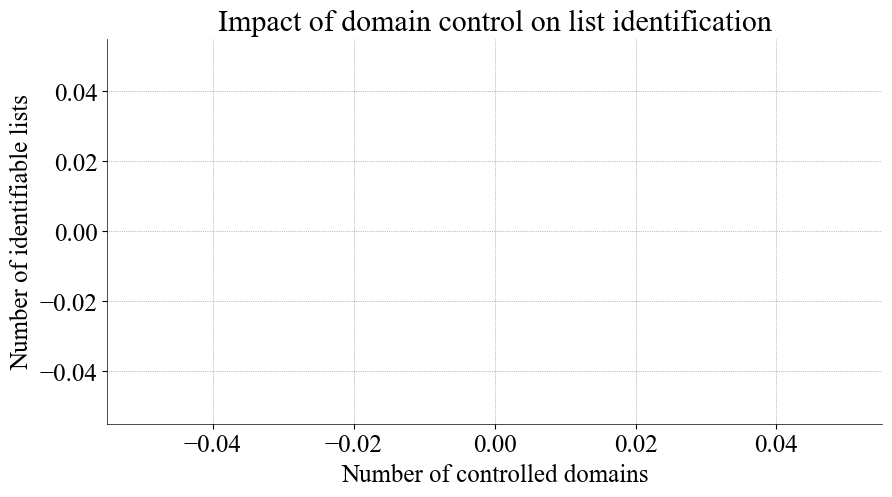

In [38]:
reload(stats)

for adblocker in ['adguard', 'ublock']:
    for list_type in ['all', 'cosmetic', 'network']:
        print(f"Processing {adblocker} {list_type} list")
        results, (fig, ax) = stats.domain_coverage_stats(DOMAIN_SPECIFIC_STATS[adblocker][list_type], LIST_IDENTIFIABLE_RULE_COUNTS[adblocker][list_type])
        
        results.to_csv(f"figures/tables/domain_coverage_stats_{adblocker}_{list_type}.csv", index=False)
        fig.savefig(f"figures/domain_coverage_stats_{adblocker}_{list_type}.pdf")

In [34]:
# repeat it after removing the top 1k domains

def filter_out_domains(df, domains):
    
    suffix_tree = DomainTree(list(df.domain.values))
    prefix_tree = DomainTree(list(df.domain.values), reverse=True)
    
    domains_to_remove = []
    
    for domain in domains:
        
        prefixes = prefix_tree.subsets_for(domain)
        suffixes = suffix_tree.subsets_for(domain)
        
        domains_to_remove.extend(prefixes)
        domains_to_remove.extend(suffixes)
        
    return df[df['domain'].isin(domains_to_remove) == False].copy()


In [35]:
# repeat stats
reload(stats)
# Count the domains
table = []

for adblocker in ["adguard", "ublock"]:
    for rule_type in ["all", "cosmetic", "network"]:
        domain_count = DOMAIN_SPECIFIC_STATS[adblocker][rule_type]
        table.append({"adblocker": adblocker, "rule_type": rule_type,**stats.domain_counts_stats(filter_out_domains(domain_count, TOP_1K_DOMAINS.domain.values))})
        
        
pd.DataFrame(table)

Domain game.hiroba.dpoint.docomo.ne.jp is too long
Domain nutsinbulk.co.uk.careers.equinix.com is too long
Domain microsoft.public.tw.security.narkive.com is too long
Domain microsoft.public.it.office.excel.narkive.com is too long
Domain game.hiroba.dpoint.docomo.ne.jp is too long
Domain nutsinbulk.co.uk.careers.equinix.com is too long
Domain microsoft.public.tw.security.narkive.com is too long
Domain microsoft.public.it.office.excel.narkive.com is too long
Domain game.hiroba.dpoint.docomo.ne.jp is too long
Domain nutsinbulk.co.uk.careers.equinix.com is too long
Domain microsoft.public.tw.security.narkive.com is too long
Domain microsoft.public.it.office.excel.narkive.com is too long
Domain game.hiroba.dpoint.docomo.ne.jp is too long
Domain nutsinbulk.co.uk.careers.equinix.com is too long
Domain microsoft.public.tw.security.narkive.com is too long
Domain microsoft.public.it.office.excel.narkive.com is too long
Domain game.hiroba.dpoint.docomo.ne.jp is too long
Domain nutsinbulk.co.uk.c

,adblocker,rule_type,n_domains,max_rules,min_rules,median_rules,max_lists,min_lists,median_lists
0,adguard,all,137147,128159.0,1.0,3.0,45,1,2.0
1,adguard,cosmetic,127541,123201.0,1.0,3.0,41,1,2.0
2,adguard,network,26609,4503.0,1.0,2.0,18,1,1.0
3,ublock,all,132803,50909.0,1.0,2.0,34,1,1.0
4,ublock,cosmetic,123657,46696.0,1.0,2.0,31,1,1.0
5,ublock,network,26277,671.0,1.0,1.0,11,1,1.0


Processing adguard all list
Total lists: 83, Unique lists: 71
Domain: lelum.pl, Additional lists: 5, Total lists: 76
Domain: m.ua, Additional lists: 3, Total lists: 79
Domain: xda-developers.com, Additional lists: 2, Total lists: 81
Domain: jut.su, Additional lists: 1, Total lists: 82
Domain: avic.ua, Additional lists: 1, Total lists: 83
Processing adguard cosmetic list
Total lists: 83, Unique lists: 58
Domain: lelum.pl, Additional lists: 6, Total lists: 64
Domain: m.ua, Additional lists: 4, Total lists: 68
Domain: r.mail.ru, Additional lists: 3, Total lists: 71
Domain: op.gg, Additional lists: 1, Total lists: 72
Domain: jut.su, Additional lists: 1, Total lists: 73
Domain: tnn.lk, Additional lists: 1, Total lists: 74
Domain: cc.com, Additional lists: 1, Total lists: 75
Domain: hrw.org, Additional lists: 1, Total lists: 76
Domain: avic.ua, Additional lists: 1, Total lists: 77
Domain: google.md, Additional lists: 1, Total lists: 78
Domain: booklips.pl, Additional lists: 1, Total lists: 7

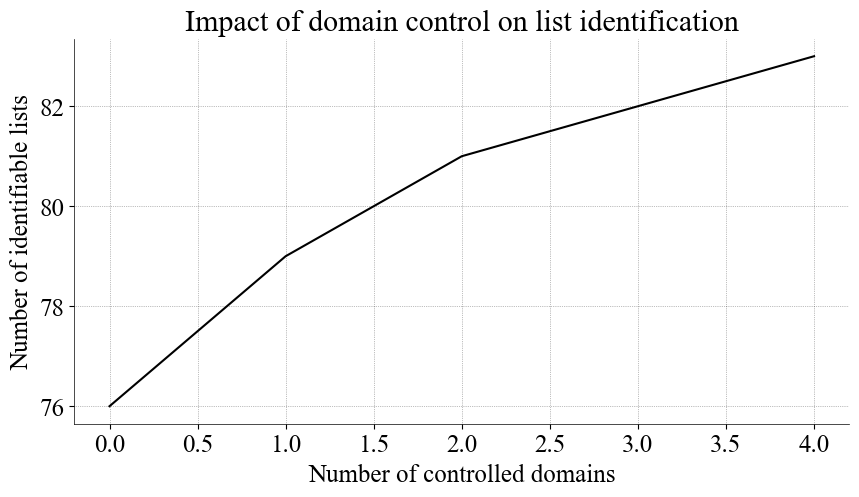

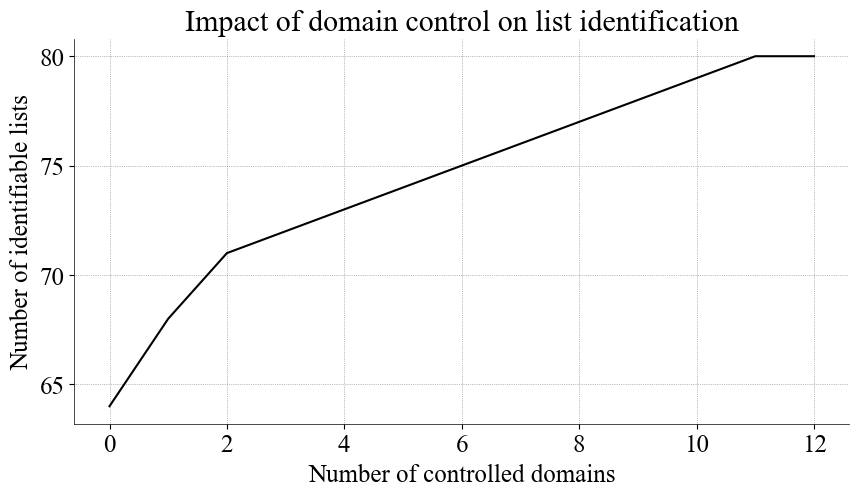

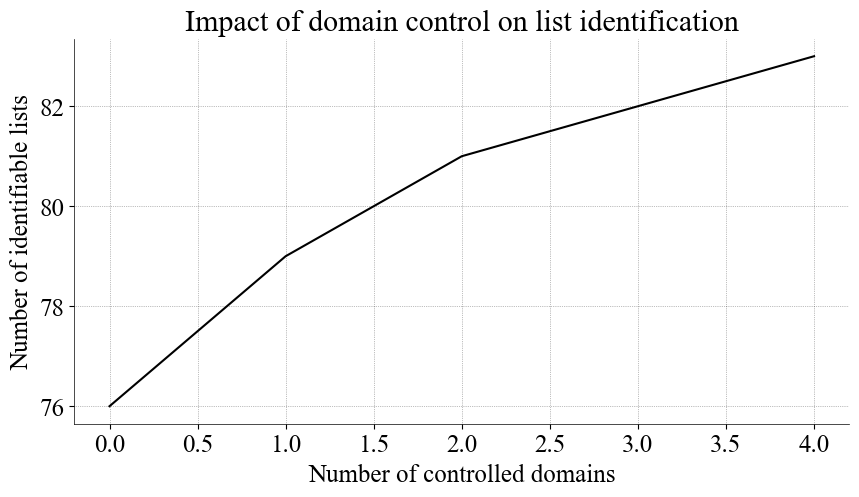

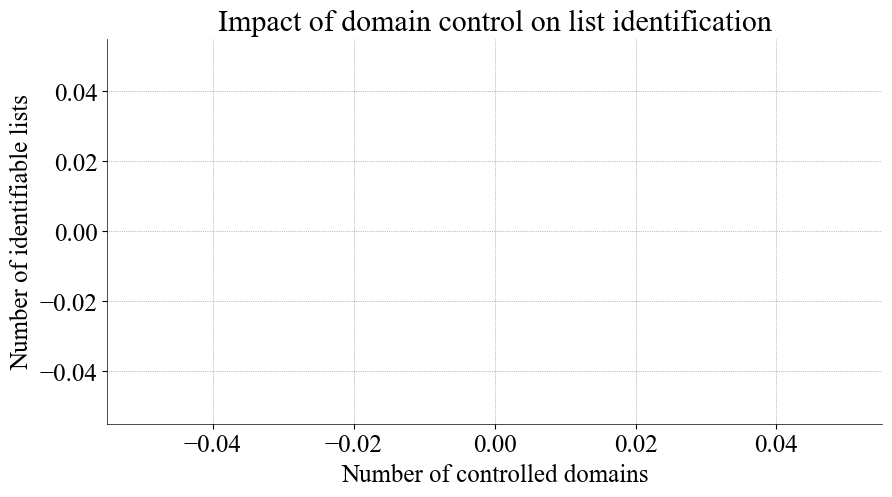

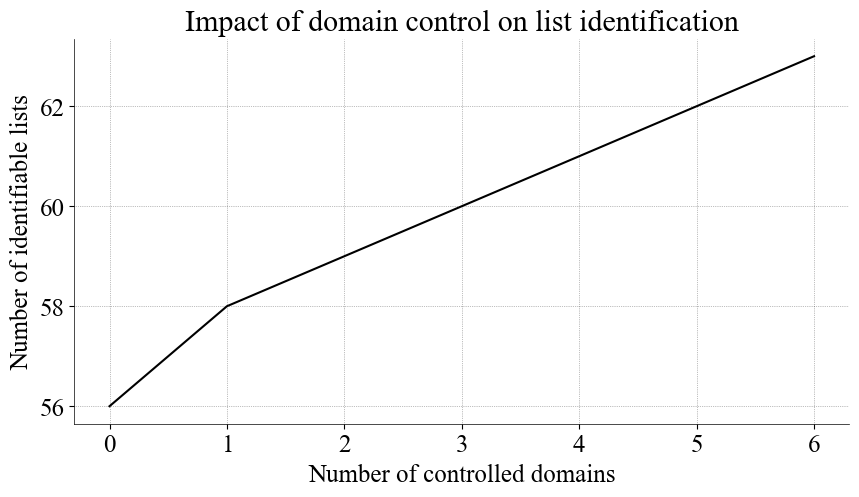

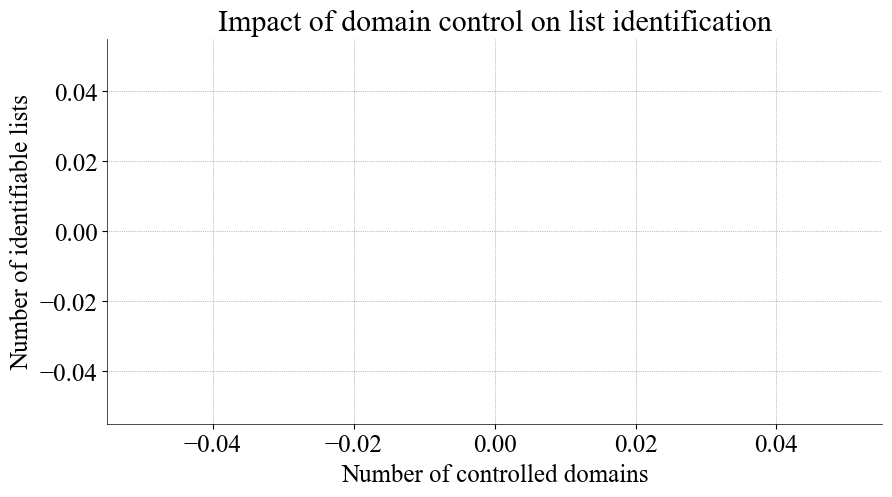

In [37]:
reload(stats)

for adblocker in ['adguard', 'ublock']:
    for list_type in ['all', 'cosmetic', 'network']:
        print(f"Processing {adblocker} {list_type} list")
        domain_count = DOMAIN_SPECIFIC_STATS[adblocker][rule_type]
        domain_count = filter_out_domains(domain_count, TOP_1K_DOMAINS.domain.values)
        results, (fig, ax) = stats.domain_coverage_stats(domain_count, LIST_IDENTIFIABLE_RULE_COUNTS[adblocker][list_type])
        
        results.to_csv(f"figures/tables/domain_coverage_stats_no1k_{adblocker}_{list_type}.csv", index=False)
        fig.savefig(f"figures/domain_coverage_stats_no1k_{adblocker}_{list_type}.pdf")